# Genetic Algorithms vs Dynamic Programming for the Knapsack Problem


## Introduction:

In this project, I will be using **Genetic Algorithms** and **Dynamic Programming** to find the solution to a 01-Knapsack Problem. The Knapsack Problem is an optimization problem where we're given a set of weights and values of $n$ objects, collect them into a bag (or a "knapsack") of maximum value such that their cumulative weight does not exceed capacity. The goal is to get the maximum value from the items in the knapsack. Since this problem is a 01-Knapsack, we can only take one of each object, or none.


In notation form, we are trying to maximize $\sum_{i=1}^{n} (values[i]*choices[i])$ subject to $\sum_{i=1}^{n} (weights[i]*choices[i]) \leq capacity$, where $weights[i] \in {0,1}$.

By the end of this project, I will maximize the above equations using Genetic Algorithms and Dynamic Programming, and **compare their results** in my final report.

## Approach:  
My GA will proceed in the following steps:
- 1. Create the population
- 2. Rank the population according to fitness in decreasing order
- 3. Select the mating pool
- 4. Breed
- 5. Mutate to create the next generation
- 6. Repeat  

Now, let’s see this in action!

## Coding the Genetic Algorithm:

In [1]:
# Importing everything I will need for this project.
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import operator
import math
from sklearn.datasets import load_breast_cancer
import sklearn
from sklearn.model_selection import train_test_split
from datetime import datetime

### Creating the Knapsack Game
Each unique Knapsack game has its own $capacity$ value, $weights$ vector, and $values$ vector. Below is a function used to randomly create a knapsack game of specified size (size = number of objects in knapsack game). I used this function to create a game of size 300 that will be used for Genetic Algortihm and Dynamic Programming for comparison later on. 

The functions saveGame() and loadGame() are used to save the game as a file and re-load this file into the notebook, so that everyone is using the same randomly created game. I was provided the game file on Canvas, by my instructors for this report, and thus we load this file in using the function loadGame(). The game file must be in the same folder as this assignment file. You can upload files to Colab using the file icon in the left pane.

In [2]:
def createGame(size):
    """
    size : the number of objects in the knapsack game
    This function should return a knapsack game in dictionary form 
    """
    upperbound = size // 20 
    choices = range(1, upperbound)
    values = []
    weights = []

    totalWeight = 0
    for i in range(size):
        values.append(random.choice(choices))
        weights.append(random.choice(choices))
        totalWeight += weights[i]
    

    capacity = totalWeight // 2

    game = {'values': values, 'weights': weights, 'capacity': capacity}
    print("Capacity: " + str(capacity))

    return game 

def saveGame(game):
    N = len(game['values'])
    combined = np.array(game['values'] + game['weights'] + [game['capacity']])
    np.savetxt('game.txt', combined)

def loadGame(fname):
    """
    This function loads a knapsack game (weights, values and capacity) from the
    specified file. It returns a dictionary containing these 3 game parameters
    """

    combined = np.loadtxt(fname)
    N = (len(combined) - 1) // 2

    values = combined[:N].tolist()
    weights = combined[N:2*N].tolist()
    capacity = combined[-1]

    return {'values': values, 'weights': weights, 'capacity': capacity}

In [3]:
game = loadGame('game_updated.txt')

### Creating the Allocation (solution) Class
We first create a class that will represent and handle an individual in the population, called an Allocation, or a Knapsack Solution. An Allocation is represented by a $choices$ array of 0's and 1's, representing whether we took each object, and a weight variable.

Fitness is calculated as the total value of this Allocation. If $values$ and $choices$ are two arrays each representing every object in this game, this total value is equal to the sum of $value[i]*choices[i]$ for every object in the game. In other words, $\sum_{i=1}^{n} (values[i]*choices[i])$ = fitness for an Allocation with a $choices$ array and a Knapsack game with a $values$ array.





In [4]:
class Allocation:
    def __init__(self, choices):
        """
        choices : an array representing this Allocation's knapsack object choices
        weight : the total weight of this Allocation (assigned later on)
        """
        self.choices = choices
        self.weight = 0
    
    def fitness(self,game):
        """
        game : dictionary containing values, weights, and capacity 
        This fitness function is defined as the total value of this Allocation.
        """
        
        fitness = np.dot(game['values'],self.choices)
        weight = np.dot(game['weights'],self.choices)
        if weight > game['capacity']:
            return -1 

        return fitness

### Create our initial population
This is essentially an Allocation generator.  
Here I create a function that produces random Allocations. We can use it to make our initial population (aka first generation)! Then, to create an individual, we randomly select the choice for each object in the knapsack problem. This means that for each object, we decide whether we take the object in the knapsack (assign a value of 1 to choices), or not (assign a value of 0). It's important to note that even though we are starting out with a completely random initial population, there is still a chance for convergence. 

The first function here produces one random individual, and in the next function, we create the whole initial population by repeatedly calling randomAllocation().

In [5]:
def randomAllocation(game):
    """
    Creates a random Allocation. The elements of the choices array are randomly assigned (0 or 1)
    """
    choices_list = []
    
    for n in range(len(game['values'])):
        choices_list.append(random.randint(0,1))
        
    alc = Allocation(choices_list)
    return alc

def initialPopulation(game, popSize):
    """
    Create inital population of a given size.
    Returns a list of random Allocations
    """
    pop = []
    for i in range(popSize):
        temp = randomAllocation(game)
        pop.append(temp)
    
    return pop 

### Ranking by Fitness
Here, I Rank all individuals. Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the Allocation IDs and each associated fitness score.

In [6]:
def rankPopulation(game, population):
    """
    This function sorts the given population in decreasing order of the fitness score.
    Returns a list of ordered pairs of (index, fitness) where index is the index of the
    individual within the population
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = population[i].fitness(game)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Selecting a mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”),tournament selection, or elitism:
- Fitness proportionate selection (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  
- Elitism: The best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  

For the purpose of clarity, I’ll create the mating pool in two steps. First, I’ll use the output from rankPopulation to determine which Allocations to select in our selection function. Then, I set up the roulette wheel by calculating a relative fitness weight for each individual. Next, I compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best Allocations, so we introduce elitism. Ultimately, the selection function returns a list of Allocation IDs, which we can use to create the mating pool in the matingPool function.

In [7]:
def selection(popRanked, eliteSize):
    """
    popRanked: output of rankpopulation()
    eliteSize: number of highest ranked individuals we will retain in the next generation
    This function returns a list of indices of individuals selected to form the mating pool
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the Allocations that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [8]:
def matingPool(population, selectionResults):
    """
    Create the mating pool
    """
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Breeding

With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). Again, each Allocation can be represented by the choices array. 

You will implement three crossover funtions, and each one will produce two children, for a more efficient breeding. The three crossovers I use here are:
- Split Crossover
- Reversed Crossover
- Halved Crossover

In the **split crossover**, I randomly select an index to split the parents each into two parts, and create two children. The first child should be comprised of the first part of parent1, and the second part of parent2. The second child should be comprised of the first part of parent2, and the second part of parent1.  

In the **Reversed Crossover**, I once again randomly select an index to split the parents, but when it comes to making children, I reattach the splices of genes in reverse order. 

In the **Halved Crossover**, I split the gene pool directly in half of each parent, and offspring 1 is comprised of the first half of parent 1 and second of parent 2, and vise versa for offspring 2.

There is a crossover wrapper function, which is what gets called later on. Inside of this function, based on the passed crossover type, we call the appopriate function to be used in the genetic algorithm.

In [9]:
def crossover_split(sol1, sol2):
    """
    sol1, sol2: type Allocation
    Split crossover as described in the write-up
    This function should return two Allocation objects
    """
    splice1 = random.randint(0,len(sol1.choices))

    sol2_beginning_index = sol2.choices[:splice1]
    sol2_ending_index = sol2.choices[splice1:]

    sol1_beginning_index = sol1.choices[:splice1]
    sol1_ending_index = sol1.choices[splice1:]
    
    offspring_1 = Allocation(sol1_beginning_index + sol2_ending_index)
    offspring_2 = Allocation(sol2_beginning_index + sol1_ending_index)
    
    return offspring_1, offspring_2

#I'll be using this on the following crossover
def reverse(lst):
    return [ele for ele in reversed(lst)]

def reverse_crossover_split(sol1, sol2):
    """
    Your own crossover function. It should return two children created by 
    crossing over sol1 and sol2
    This function should return two Allocation objects
    """
    splice1 = random.randint(0,len(sol1.choices))

    sol2_beginning_index = sol2.choices[:splice1]
    sol2_ending_index = sol2.choices[splice1:]
    sol2_beginning_index = reverse(sol2_beginning_index)
    sol2_ending_index = reverse(sol2_ending_index)

    sol1_beginning_index = sol1.choices[:splice1]
    sol1_ending_index = sol1.choices[splice1:]
    sol1_beginning_index = reverse(sol1_beginning_index)
    sol1_ending_index = reverse(sol1_ending_index)

    offspring_1 = Allocation(sol2_ending_index + sol1_beginning_index)
    offspring_2 = Allocation(sol1_ending_index + sol2_beginning_index)
    
    return offspring_1, offspring_2

def half_crossover(sol1, sol2):
    """
    Your own crossover function. It should return two children created by 
    crossing over sol1 and sol2
    This function should return two Allocation objects
    """
    half1 = len(sol1.choices)//2
    half2 = len(sol2.choices)//2

    sol2_beginning_index = sol2.choices[:half2]
    sol2_ending_index = sol2.choices[half2:]

    sol1_beginning_index = sol1.choices[:half1]
    sol1_ending_index = sol1.choices[half1:]

    offspring_1 = Allocation(sol1_beginning_index + sol2_ending_index)
    offspring_2 = Allocation(sol2_beginning_index + sol1_ending_index)

    
    return offspring_1, offspring_2


def crossover(sol1, sol2, crossover_type):
    """
    Wrapper function for crossover. Returns the children formed by crossing over 
    sol1 and sol2. 
    crossover_type is a string specifying which crossover function to use.
    """
    if crossover_type == "split":
        return crossover_split(sol1, sol2)
    elif crossover_type == "reverse":
        return reverse_crossover_split(sol1, sol2)
    elif crossover_type == "half":
        return half_crossover(sol1, sol2)

    
    print("Crossover type invalid")
    return None 

Next, we’ll generalize this to create our offspring population. We will use elitism to retain the best Allocations from the current population. Then, we use the crossover wrapper function to fill out the rest of the next generation.

Keep in mind that when calling crossover for two parents, the function will return two children. The children population size will be equal to the size of the original population, or the size of the matingPool. 

Another note to keep in mind is that the top eliteSize members of each population should progress to the next generation without being changed or mutated. When running the genetic Algorithm function, I made sure to use an **even** eliteSize, to make calculations easier in the below function. 

In [10]:
def breedPopulation(matingpool, eliteSize, crossover_type):
    """
    matingpool: list of individuals selected to form the mating pool
    eliteSize: number of highest ranked individuals preserved in the next generation
    crossover_type: string specifying which crossover function to use
    This function returns the new population created by breeding
    """
    children = []
    length = len(matingpool) - eliteSize
    length = length // 2
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child1, child2 = crossover(pool[i], pool[len(matingpool)-i-1], crossover_type)
        children.append(child1)
        children.append(child2)
    return children

### Mutating
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. For mutating my population pool, I chose to randomly select a single point from each offspring, then mutate that number into either a 0 or a 1.

In [11]:
def mutate(individual):
    """
    individual: type Allocation
    This function should mutate a single individual and return the mutated individual.
    """
    chosen_individual = random.sample(range(0, len(individual.choices)), 1)
    for i in chosen_individual:
        individual.choices[i] = random.randint(0,1)

    return individual

Next, I extend the mutate function to run through the enitre (new) population.

In [12]:
def mutatePopulation(population, mutationRate, eliteSize):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population, and mutate each individual with probability mutationRate. 
    The top eliteSize members should remain unchanged. 
    """
    new_population = list(population)
    mutation_population = new_population[eliteSize:]

    for i in mutation_population:
        i = mutate(i)
        mutated_population = population[:eliteSize] + mutation_population
    return mutated_population

### Repeating this whole Process
Now its time to create a function that produces a new generation. First, we rank the Allocations in the current generation using rankPopulation. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we create our new generation using the breedPopulation function (passing in crossover_type) and then applying mutation using the mutatePopulation function.

In [13]:
def nextGeneration(game, currentGen, eliteSize, mutationRate, crossover_type):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    Please use all the above defined functions to do so, some hints are in the above paragraph.
    """
    popRanked = rankPopulation(game, currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, crossover_type)
    nextGeneration = mutatePopulation(children, mutationRate, eliteSize)
    return nextGeneration

### Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. 

Of course we also want to see the best Allocation and how much we’ve improved, so we capture the initial fitness, the final fitness, and the best individual. The parameter crossover_type is a string which specifies which crossover function to use. We have the parameter game as a dictionary that is returned by createLargeGame(), and we pass this variable in to other function calls as needed.

Before each generation, I use the fittest individual from the population to evaluate the fitness performance of the model.

In [14]:
def geneticAlgorithm(game, popSize, eliteSize, mutationRate, generations, crossover_type):
    """
    This function should run the genetic algorithm for the specified number of generations
    by following the process outlined  in the "Approach" section given earlier in this notebook. 
    It should print the initial and final fitness.
    It should also generate plots showing the fitness with respect to generations.
    """
    for num in range(1,6):
        start = datetime.now()

        currentGen = initialPopulation(game,popSize) 
        initial_fitness_score = rankPopulation(game,currentGen)[:][:][0]
        max_initial_fitness = max(initial_fitness_score)
        best_individual = max_initial_fitness
        
        best_ind_gen = 0
        highest_fit_list = []
    
        for gen in range(generations):    
            currentGen = nextGeneration(game, currentGen, eliteSize, mutationRate, crossover_type)
            highest_fit_list.append(max(rankPopulation(game,currentGen)[:][:][0]))
        
            if max(rankPopulation(game,currentGen)[:][:][0]) > best_individual:
                best_individual = max(rankPopulation(game,currentGen)[:][:][0])
                best_ind_gen = gen + 1
            
        final_fit = max(rankPopulation(game,currentGen)[:][:][0])

        end = datetime.now()
        print("Iteration:", num)
        print("Total Time for Genetic Algorithm: " + str(end - start))
        print("Initial Fitness Score:", max_initial_fitness)
        print("Final Fitness Score:", final_fit)
        print("The best Fitness score is", best_individual, "and its from generation", best_ind_gen)
    


        plt.plot(range(generations),highest_fit_list, label='%s iterration' % num)
        plt.title('Fitness Across All Generations')
        plt.xlabel('Generations')
        plt.ylabel("Fitness Score")
        plt.legend()

## Coding the Dynamic Programming:

Dynamic Programming is a very useful and popular way of solving many problems in computer science. The technique makes use of repeated function calling, and creates an array or table to store answers to subproblems of our actual problem. 

Our DP array will be defined by the following: $dp[i][j]$ represents the maximum knapsack profit for capacity $j$ calculated from the first $i$ items. This means that each value $dp[i][j]$ depends on previous array elements, and we fill in this array from the bottom-up. Each element in this array represents the solution to a smaller, similar Knapsack subproblem. 

For each item at index $i$ and capacity $j$ there are two options: 

1. Include the item at index $i$ in the knapsack, as long as its weight is not more than $capacity$. If this happens, we get its profit plus the profit we get from the remaining $capacity$ and remaining items: $dp[i][j] = values[i] + dp[i-1][j-weights[i]]$

2. Do not include the item at index $i$. In this case, take whatever profit we get from the sub-array that does not include this item: $dp[i][j] = dp[i-1][j]$

In [15]:
def knapsackDP(game):
    """
    values : values of the objects
    weights: weights of the objects
    capacity: capacity of the game 
    Dynamic Programming for the Knapsack problem. 
    """
    values = game['values']
    weights = game['weights']
    capacity =  game['capacity']
    capacity = int(capacity)
    
    n = len(values)
    start = datetime.now()

    dp = [[0 for _ in range(capacity + 1)] for _ in range(n)]

    for c in range(capacity + 1):
        if weights[0] <= c:
            dp[0][c] = values[0]

    for i in range(1, n):
        for j in range(1, capacity + 1):
            profit1, profit2 = 0, 0
            if weights[i] <= j:
                profit1 = values[i] + dp[i-1][j - int(weights[i])]
            profit2 = dp[i-1][j]

            dp[i][j] = max(profit1, profit2)
    
    end = datetime.now()
    print("Time elapsed for DP: " + str(end - start))
    print("Final DP sol: " + str(dp[n-1][capacity]))
    return dp[n-1][capacity]

In [16]:
knapsackDP(game)

Time elapsed for DP: 0:00:00.160039
Final DP sol: 1757.0


1757.0

Now I run the Genetic Algorithm with the same game.

Iteration: 1
Total Time for Genetic Algorithm: 0:02:51.646567
Initial Fitness Score: 1188.0
Final Fitness Score: 1745.0
The best Fitness score is 1745.0 and its from generation 760
Iteration: 2
Total Time for Genetic Algorithm: 0:02:51.861277
Initial Fitness Score: 1239.0
Final Fitness Score: 1745.0
The best Fitness score is 1745.0 and its from generation 751
Iteration: 3
Total Time for Genetic Algorithm: 0:02:52.070115
Initial Fitness Score: 1191.0
Final Fitness Score: 1744.0
The best Fitness score is 1744.0 and its from generation 638
Iteration: 4
Total Time for Genetic Algorithm: 0:02:52.095888
Initial Fitness Score: 1181.0
Final Fitness Score: 1741.0
The best Fitness score is 1741.0 and its from generation 731
Iteration: 5
Total Time for Genetic Algorithm: 0:02:51.597141
Initial Fitness Score: 1227.0
Final Fitness Score: 1743.0
The best Fitness score is 1743.0 and its from generation 663


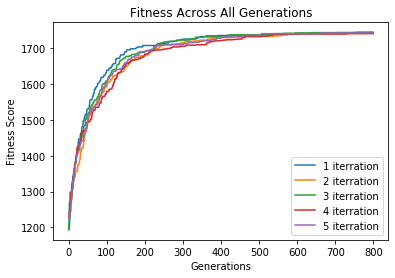

In [17]:
geneticAlgorithm(game = game, popSize = 300, eliteSize = 20, mutationRate = 0.3, generations = 800, crossover_type = "split")

Iteration: 1
Total Time for Genetic Algorithm: 0:02:45.842056
Initial Fitness Score: 1177.0
Final Fitness Score: 1573.0
The best Fitness score is 1573.0 and its from generation 310
Iteration: 2
Total Time for Genetic Algorithm: 0:02:45.711931
Initial Fitness Score: 1196.0
Final Fitness Score: 1587.0
The best Fitness score is 1587.0 and its from generation 791
Iteration: 3
Total Time for Genetic Algorithm: 0:02:44.861070
Initial Fitness Score: 1200.0
Final Fitness Score: 1613.0
The best Fitness score is 1613.0 and its from generation 775
Iteration: 4
Total Time for Genetic Algorithm: 0:02:45.860202
Initial Fitness Score: 1230.0
Final Fitness Score: 1603.0
The best Fitness score is 1603.0 and its from generation 786
Iteration: 5
Total Time for Genetic Algorithm: 0:02:45.223349
Initial Fitness Score: 1172.0
Final Fitness Score: 1610.0
The best Fitness score is 1610.0 and its from generation 684


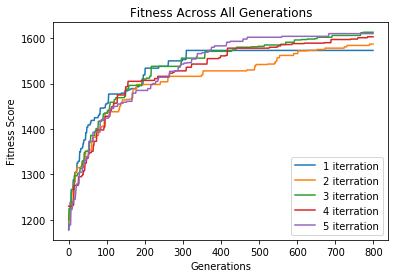

In [18]:
geneticAlgorithm(game = game, popSize = 300, eliteSize = 20, mutationRate = 0.3, generations = 800, crossover_type = "reverse")

Iteration: 1
Total Time for Genetic Algorithm: 0:02:52.719195
Initial Fitness Score: 1185.0
Final Fitness Score: 1744.0
The best Fitness score is 1744.0 and its from generation 711
Iteration: 2
Total Time for Genetic Algorithm: 0:02:51.986409
Initial Fitness Score: 1222.0
Final Fitness Score: 1738.0
The best Fitness score is 1738.0 and its from generation 778
Iteration: 3
Total Time for Genetic Algorithm: 0:02:52.351303
Initial Fitness Score: 1231.0
Final Fitness Score: 1741.0
The best Fitness score is 1741.0 and its from generation 783
Iteration: 4
Total Time for Genetic Algorithm: 0:02:52.453984
Initial Fitness Score: 1194.0
Final Fitness Score: 1744.0
The best Fitness score is 1744.0 and its from generation 790
Iteration: 5
Total Time for Genetic Algorithm: 0:02:53.016624
Initial Fitness Score: 1207.0
Final Fitness Score: 1736.0
The best Fitness score is 1736.0 and its from generation 774


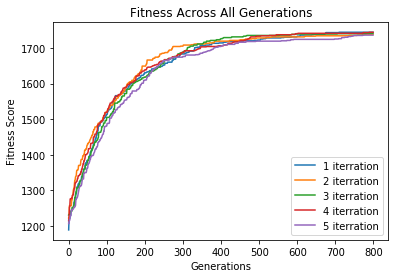

In [19]:
geneticAlgorithm(game = game, popSize = 300, eliteSize = 20, mutationRate = 0.3, generations = 800, crossover_type = "half")